In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
%matplotlib inline

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим данные и сделаем первичный осмотр.

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data_copy = data
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные не в чистом виде, присутсвуют как и ошибки приведения типов, так и пропуски в данных, будем исправлять!

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проанализируем конкретно в каких признаках у нас имеются пропуски.

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Первым делом исправим самую явную ошибку приведения типов - признак *Repaired*, его следует привести к типу Bool, предварительно заполним пропуски значением False, так как если поле пустой - скорее всего пользователи имели в виду, что она не чинилась, поэтому ничего и не вводили.

In [6]:
tmp_repaired = [True if i == 'yes' else False for i in data['Repaired']]

In [7]:
data['Repaired'] = tmp_repaired

Удалим признаки: *NumberOfPictures* - он содержит только нули и никакой информации не несёт, *DateCrawled*, *DateCreated*, *LastSeen*, *PostalCode* - признаки, никак не влияющие на цену.

In [8]:
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"], axis=1)

С остальными признаками чуть тяжелее - они все категориальные. Конечно, можно попытаться восстановить их на основе других данных, например восстановить тип техники по бренду и мощности двигателя, но такую группировку лучше согласовывать с заказчиком или спросить у более опытных коллег. Поэтому пока заполним пропуски "unknown".

In [9]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')

Настало время разобраться с аномальными значениями.

In [10]:
data['RegistrationYear']

0         1993
1         2011
2         2004
3         2001
4         2008
          ... 
354364    2005
354365    2005
354366    2000
354367    1996
354368    2002
Name: RegistrationYear, Length: 354369, dtype: int64

In [11]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1
data.loc[data['Power'] > 3000, 'Power'] = 3000
data["RegistrationYear"] = data["RegistrationYear"].where(data["RegistrationYear"] < pd.to_datetime(data_copy['DateCreated']).dt.year, pd.to_datetime(data_copy['DateCreated']).dt.year)
data["RegistrationYear"] = data["RegistrationYear"].where(data["RegistrationYear"] > 1940, 1940)

In [12]:
data['RegistrationYear'].sort_values()

33638     1940
117371    1940
225151    1940
26216     1940
79120     1940
          ... 
275220    2016
127981    2016
176228    2016
71083     2016
289428    2016
Name: RegistrationYear, Length: 354369, dtype: int64

Теперь разберемся с выбросами. Построим диаграмму размаха и оценим ситуацию.

(-50.0, 20000.0)

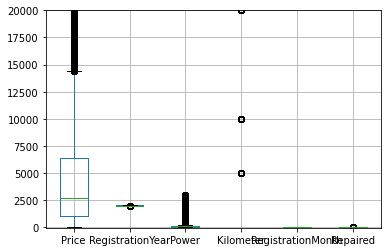

In [13]:
data.boxplot()
plt.ylim(-50, 20000)

Как оказалось, выбросов очень много, нужно обрабатывать в признаках *Price* и *Power*.


Обработаем выбросы.

In [14]:
count = 0
index_del = []
for column in ["Price","Power"]:
    q25=np.array(data[column].quantile(0.25))
    q75=np.array(data[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    for index_value, value in zip(data[column].index,data[column]):
        if second_part <= value or value <= first_part:
            index_del.append(index_value)
    count += len(index_del)
    data = data.drop(index_del, axis = 0)
    index_del = []

## Обучение моделей

Разделим на фичи и таргет.

In [15]:
features_NEW = data.drop('Price', axis=1)
target_NEW = data['Price']
features_NEW

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,unknown,1993,manual,0,golf,150000,1,petrol,volkswagen,False
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,False
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,False
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,False
5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,True
...,...,...,...,...,...,...,...,...,...,...
354364,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,True
354365,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,False
354366,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,False
354367,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,False


Теперь поделим данные на обучающую и тестовую выборки в соотношении 3:1.

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features_NEW, target_NEW, test_size=0.2, random_state=12345)

In [18]:
cat_features = ['VehicleType', 'Model', 'FuelType', 'Gearbox', 'Repaired', 'RegistrationMonth', 'Brand']
num_features = ['Power', 'Kilometer', 'RegistrationYear']

Теперь приступим к обучению моделей, начнём с малого - Линейная Регрессия. Но для начала - отмасштабируем данные.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330237 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              330237 non-null  int64 
 1   VehicleType        330237 non-null  object
 2   RegistrationYear   330237 non-null  int64 
 3   Gearbox            330237 non-null  object
 4   Power              330237 non-null  int64 
 5   Model              330237 non-null  object
 6   Kilometer          330237 non-null  int64 
 7   RegistrationMonth  330237 non-null  int64 
 8   FuelType           330237 non-null  object
 9   Brand              330237 non-null  object
 10  Repaired           330237 non-null  bool  
dtypes: bool(1), int64(5), object(5)
memory usage: 28.0+ MB


In [23]:
lin_column_transformer = ColumnTransformer([('num', StandardScaler(), num_features), ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)])
lin_pipe = Pipeline([('ct', lin_column_transformer), ('model', LinearRegression())])

In [24]:
%%time

lin_pipe.fit(features_train, target_train)
scores = cross_val_score(lin_pipe, features_train, target_train, cv=5, verbose=True, n_jobs=-1, scoring='neg_root_mean_squared_error')
final_score = sum(scores) / len(scores)

print('Средняя оценка качества модели:', final_score)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Средняя оценка качества модели: -2224.3626294882424
CPU times: user 1min 54s, sys: 2min 23s, total: 4min 17s
Wall time: 4min 18s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


In [25]:
%%time

print('RMSE:', mean_squared_error(y_true=target_train, y_pred=lin_pipe.predict(features_train), squared=False))

RMSE: 2220.3319567622875
CPU times: user 617 ms, sys: 46.6 ms, total: 663 ms
Wall time: 672 ms


Теперь воспользуемся случайным лесом с подбором гипперпараметров.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'max_depth': 40, 'n_estimators': 9}
Лучший счет: -1812.5861995571854

In [27]:
forest_pipe = Pipeline([('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), ('model', RandomForestRegressor(random_state=12345, n_jobs=-1))])

In [28]:
params = {'model__max_depth': range (10, 41, 10), 'model__n_estimators': range(1, 11, 2)}
grid = GridSearchCV(forest_pipe, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=10)
grid.fit(features_train, target_train)
print('Лучшие параметры:', grid.best_params_)
print('Лучший счет:', grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__max_depth=10, model__n_estimators=1.................
[CV 1/5; 1/20] END model__max_depth=10, model__n_estimators=1;, score=-1761.508 total time=   0.9s
[CV 2/5; 1/20] START model__max_depth=10, model__n_estimators=1.................
[CV 2/5; 1/20] END model__max_depth=10, model__n_estimators=1;, score=-1747.840 total time=   0.8s
[CV 3/5; 1/20] START model__max_depth=10, model__n_estimators=1.................
[CV 3/5; 1/20] END model__max_depth=10, model__n_estimators=1;, score=-1758.749 total time=   0.8s
[CV 4/5; 1/20] START model__max_depth=10, model__n_estimators=1.................
[CV 4/5; 1/20] END model__max_depth=10, model__n_estimators=1;, score=-1764.949 total time=   0.9s
[CV 5/5; 1/20] START model__max_depth=10, model__n_estimators=1.................
[CV 5/5; 1/20] END model__max_depth=10, model__n_estimators=1;, score=-1767.727 total time=   0.9s
[CV 1/5; 2/20] START model__max_depth=

In [29]:
forest_pipe = Pipeline([('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), ('model', RandomForestRegressor(max_depth=20, n_estimators=9, random_state=12345, n_jobs=-1))])

In [30]:
%%time
forest_pipe.fit(features_train, target_train)

CPU times: user 7.65 s, sys: 56.2 ms, total: 7.7 s
Wall time: 7.72 s


Pipeline(steps=[('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=9, n_jobs=-1,
                                       random_state=12345))])

In [31]:
%%time
predictions_forest = forest_pipe.predict(features_train)


CPU times: user 1.13 s, sys: 2.4 ms, total: 1.14 s
Wall time: 1.15 s


In [32]:
print('RMSE:', mean_squared_error(y_true=target_train, y_pred=predictions_forest, squared=False))

RMSE: 911.2009430263598


Теперь воспользуемся *Catboost*.


bestTest = 1725.410008
bestIteration = 999

CPU times: user 1h 29min 6s, sys: 6min 4s, total: 1h 35min 11s
Wall time: 17min 1s

In [33]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
                                     Pool(features_train_cat, target_train_cat, cat_features=["VehicleType","Gearbox",
                                                                                      "Model","FuelType",
                                                                                      "Brand","Repaired"]),
                                     cv=3,
                                     verbose=True,
                                     plot=False)

In [34]:
model_catboost = CatBoostRegressor(depth=catboost_grid["params"]["depth"],
                                    learning_rate=catboost_grid["params"]['learning_rate'], loss_function='RMSE')
model_catboost.fit(features_train_cat, target_train_cat, cat_features=["VehicleType","Gearbox",
                                                              "Model","FuelType",
                                                              "Brand","Repaired"])


In [37]:
light_column_transformer = ColumnTransformer([('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)], remainder='passthrough')
light_column_transformer.fit(features_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['VehicleType', 'Model', 'FuelType', 'Gearbox',
                                  'Repaired', 'RegistrationMonth', 'Brand'])])

In [38]:
%%time

lgb_train = lgb.Dataset(light_column_transformer.transform(features_train), target_train)
lgb_test = lgb.Dataset(light_column_transformer.transform(features_test), target_test, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                  lgb_train,
                  num_boost_round=1000,
                  valid_sets=[lgb_train, lgb_test],
                  verbose_eval=100)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.393204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 264189, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3651.704825
[100]	training's l2: 2.26363e+06	valid_1's l2: 2.29212e+06
[200]	training's l2: 2.0957e+06	valid_1's l2: 2.17011e+06
[300]	training's l2: 1.99066e+06	valid_1's l2: 2.10631e+06
[400]	training's l2: 1.91494e+06	valid_1's l2: 2.06247e+06
[500]	training's l2: 1.8578

In [39]:
%%time
print("LightGBM:",(mean_squared_error(target_train,light.predict(light_column_transformer.transform(features_train)),squared=False)))

LightGBM: 1289.6443433324612
CPU times: user 24.7 s, sys: 0 ns, total: 24.7 s
Wall time: 25 s


## Анализ моделей

Были обучены 4 модели: Линейная Регрессия, Случайный Лес, CatBoost и LightGBM. Начнем по порядку: наименьшую ошибку показал CatBoost - 1703, следом идёт LightGBM - 1719, затем Случайный Лес - 1747, а уже потом Линейная Регрессия - 3207. Разница между бустингом и регрессией колосальна. А вот разница между тремя первыми местами не сильно заметна, особенно если рассматривать только бустинги - всего в 16 евро.

Критерии, которые важны заказчику:
-качество предсказания;
-время обучения модели;
-время предсказания модели.


Отбросим линейную регрессии в силу ее слабой RMSE и за каждый критерий будем давать от 0 до 2 баллов за позицию в критериях.
Качество предсказания: CatBoost - 2 балла, LightGBM - 1 балл, Случайный Лес - 0 баллов.
Время обучения модели: CatBoost - 0 баллов, LightGBM - 2 балл, Случайный Лес - 1 балла.
Время предсказания модели: CatBoost - 2 балла, LightGBM - 1 балл, Случайный Лес - 0 баллов.

Таким образом у CatBoost - 4 балла, у LightGBM - 4 балла и у Случайного Лесса 1 балл.
Но в данном случае выбор падет на LightGBM, так как уж намного быстрее эта модель обучилась в отличие от CatBoost.

Отличный результат!

In [40]:
print("LightGBM:",(mean_squared_error(target_test,light.predict(light_column_transformer.transform(features_test)),squared=False)))

LightGBM: 1401.8145411943196


## Вывод

Была проведена работа по обработке данных, обучению модель и анализа лучшей. В самом начале мы первично изучали данные и начали их обрабатывать - было много пропусков и не все признаки соответствовали своим типам. После разбили данные на обучающую и тестовую выборки несколько раз, так как разные модели могут принимать на вход только определенные данные - некоторые уже закодированные, а некоторые могут принимать и не закодированные данные. Обучив и проверив модели на тестовых выборках - стало ясно, что линейная регрессия такая себе модель для данной задачи, а после сравнительного анализа стало ясно, что лучшая модель в нашем случае - LightGBM!